In [2]:
pip install feature_engine

In [3]:
pip install pycaret

# Segment Customers based on RFM Variables

In [5]:
# อิติปาระมิตา ติงสา อิติสัพพัญญะ มาคะตา
# อิติโพธิ มุนุปปัตโต อิติปิโส จะตะมะโน
# นะเมตตา โมกรุณา พุทธปราณี ธายินดี
# ยะเอ็นดู ยะหันตวา ธามัวเมา พุทพาเอา นะโมพุทธายะ

# %matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from keras.utils import np_utils 
import numpy as np

from pycaret.regression import * 
# from pycaret.classification import *


import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load Dataset
df = pd.read_csv('/content/sample_data/Data 3 Shops OCT 2021-JAN 2022.csv')

df = df[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article_Key','Article','Sales_Excld','Recency']]

df = df[df['Product_Champion'].isin(['Egg', 'Other ', 'Poultry', 'Process Food', 'Process Meat', 'Swine']) & df['Site_Key'].isin(['S035','S154','S031'])]
# 'Egg', 'Other', 'Poultry', 'Process Food', 'Process Meat', 'Swine'
# 'สาขามุกดาหาร' , 'สาขาธาตุพนม' ,'สาขาหนองคาย'

df
# print(df)

,รหัสลูกค้า,ช่องทาง,CalendarDay,Week,Site_Key,Site_MediumText,Product_Champion,Article_Key,Article,Sales_Excld,Recency
0,228,WHOLESALE,10/5/2021,10_W1_2021,S035,สาขามุกดาหาร,Poultry,1000005718,FR CK สันในไก่ 5กก BTG,79425.00,119
1,228,WHOLESALE,10/11/2021,10_W2_2021,S035,สาขามุกดาหาร,Poultry,1000005312,FR CK เนื้อไก่บีบีคู่ BTG 5กก,60000.00,113
2,552,WHOLESALE,10/11/2021,10_W2_2021,S154,สาขาธาตุพนม,Swine,1000002678,FR PK BTG ขาหลังหมูเผา 12KG FZ,60000.00,113
3,228,WHOLESALE,10/11/2021,10_W2_2021,S035,สาขามุกดาหาร,Poultry,1000005718,FR CK สันในไก่ 5กก BTG,45000.00,113
4,228,WHOLESALE,10/5/2021,10_W1_2021,S035,สาขามุกดาหาร,Poultry,1000005312,FR CK เนื้อไก่บีบีคู่ BTG 5กก,40000.00,119
...,...,...,...,...,...,...,...,...,...,...,...
31406,402,WHOLESALE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Poultry,1000005727,FR CK ไส้อ่อนไก่ลวก HB 1กก,156.00,1
31407,581,FOOD SERVICE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Poultry,1000005421,FR CK เลือดไก่ 5 ก้อน HB,105.00,1
31408,607,FOOD SERVICE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Other,1000003023,BO EG BTG เต้าหู้ไข่อนามัยH120ก,102.80,1
31409,188,WHOLESALE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Poultry,1000005421,FR CK เลือดไก่ 5 ก้อน HB,100.00,1


In [7]:
df.shape

(31411, 11)

## Data Preparation

In [8]:
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (31411, 11)
___________________________
Data types:
object     7
int64      3
float64    1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
Article,object,31411,502,0,BA P&C BTG ลูกชิ้นปรุงรส B 500ก
Article_Key,int64,31411,502,0,1000000985
CalendarDay,object,31411,104,0,1/10/2022
Product_Champion,object,31411,6,0,Egg
Recency,int64,31411,104,0,1
Sales_Excld,float64,31411,5385,0,0.0
Site_Key,object,31411,3,0,S031
Site_MediumText,object,31411,3,0,สาขาธาตุพนม
Week,object,31411,19,0,10_W1_2021
ช่องทาง,object,31411,3,0,FOOD SERVICE


In [9]:
df.describe()

,รหัสลูกค้า,Article_Key,Sales_Excld,Recency
count,31411.000000,3.141100e+04,31411.000000,31411.000000
mean,299.582344,1.000073e+09,1851.598059,61.078444
std,196.576451,7.979281e+06,7424.870711,34.955122
min,1.000000,1.000001e+09,0.000000,1.000000
25%,122.000000,1.000005e+09,480.000000,33.000000
50%,267.000000,1.000005e+09,850.000000,61.000000
75%,454.000000,1.000006e+09,1650.000000,90.000000
max,709.000000,2.000000e+09,792000.000000,123.000000


In [10]:
df.isnull().mean()*100

รหัสลูกค้า          0.0
ช่องทาง             0.0
CalendarDay         0.0
Week                0.0
Site_Key            0.0
Site_MediumText     0.0
Product_Champion    0.0
Article_Key         0.0
Article             0.0
Sales_Excld         0.0
Recency             0.0
dtype: float64

In [11]:
df.loc[(df.Sales_Excld<0)]

,รหัสลูกค้า,ช่องทาง,CalendarDay,Week,Site_Key,Site_MediumText,Product_Champion,Article_Key,Article,Sales_Excld,Recency


In [12]:
# #Removing the Null values from the data.
df = df[pd.notnull(df['รหัสลูกค้า'])]
df

,รหัสลูกค้า,ช่องทาง,CalendarDay,Week,Site_Key,Site_MediumText,Product_Champion,Article_Key,Article,Sales_Excld,Recency
0,228,WHOLESALE,10/5/2021,10_W1_2021,S035,สาขามุกดาหาร,Poultry,1000005718,FR CK สันในไก่ 5กก BTG,79425.00,119
1,228,WHOLESALE,10/11/2021,10_W2_2021,S035,สาขามุกดาหาร,Poultry,1000005312,FR CK เนื้อไก่บีบีคู่ BTG 5กก,60000.00,113
2,552,WHOLESALE,10/11/2021,10_W2_2021,S154,สาขาธาตุพนม,Swine,1000002678,FR PK BTG ขาหลังหมูเผา 12KG FZ,60000.00,113
3,228,WHOLESALE,10/11/2021,10_W2_2021,S035,สาขามุกดาหาร,Poultry,1000005718,FR CK สันในไก่ 5กก BTG,45000.00,113
4,228,WHOLESALE,10/5/2021,10_W1_2021,S035,สาขามุกดาหาร,Poultry,1000005312,FR CK เนื้อไก่บีบีคู่ BTG 5กก,40000.00,119
...,...,...,...,...,...,...,...,...,...,...,...
31406,402,WHOLESALE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Poultry,1000005727,FR CK ไส้อ่อนไก่ลวก HB 1กก,156.00,1
31407,581,FOOD SERVICE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Poultry,1000005421,FR CK เลือดไก่ 5 ก้อน HB,105.00,1
31408,607,FOOD SERVICE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Other,1000003023,BO EG BTG เต้าหู้ไข่อนามัยH120ก,102.80,1
31409,188,WHOLESALE,1/31/2022,2_W1_2022,S031,สาขาหนองคาย,Poultry,1000005421,FR CK เลือดไก่ 5 ก้อน HB,100.00,1


In [13]:
df['Postdate'] = pd.to_datetime(df['CalendarDay'])

In [14]:
df.isnull().mean()

รหัสลูกค้า          0.0
ช่องทาง             0.0
CalendarDay         0.0
Week                0.0
Site_Key            0.0
Site_MediumText     0.0
Product_Champion    0.0
Article_Key         0.0
Article             0.0
Sales_Excld         0.0
Recency             0.0
Postdate            0.0
dtype: float64

## RFM Analysis

In [15]:
NOW = dt.date(2022,2,1) 
df['Date'] = pd.DatetimeIndex(df.Postdate).date

#### Recency

In [16]:
df_recency = df.groupby(['รหัสลูกค้า'],as_index=False)['Date'].max()
df_recency.columns = ['รหัสลูกค้า','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)

In [17]:
df_recency

,รหัสลูกค้า,Recency
0,1,1
1,2,1
2,3,8
3,4,1
4,5,1
...,...,...
704,705,5
705,706,6
706,707,3
707,708,7


#### Frequency - Monetarty

In [18]:
FM_Table = df.groupby('รหัสลูกค้า').agg({'รหัสลูกค้า': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
FM_Table.rename(columns = {'รหัสลูกค้า' :'Frequency','Sales_Excld':'Monetary'},inplace= True)

In [19]:
FM_Table

,Frequency,Monetary
รหัสลูกค้า,,
1,104,77560.83
2,85,121976.60
3,34,31417.00
4,128,950734.03
5,465,313464.16
...,...,...
705,4,6278.40
706,1,1209.60
707,6,4050.37


In [20]:
RFM_Table = df_recency.merge(FM_Table,left_on='รหัสลูกค้า',right_on='รหัสลูกค้า')
RFM_Table['FM_Avg'] = (RFM_Table['Frequency'] * RFM_Table['Monetary'])/2
RFM_Table.head(10)

,รหัสลูกค้า,Recency,Frequency,Monetary,FM_Avg
0,1,1,104,77560.83,4.033163e+06
1,2,1,85,121976.60,5.184006e+06
2,3,8,34,31417.00,5.340890e+05
3,4,1,128,950734.03,6.084698e+07
4,5,1,465,313464.16,7.288042e+07
5,6,48,3,1914.00,2.871000e+03
6,7,14,20,3338.51,3.338510e+04
7,8,33,7,4472.87,1.565505e+04
8,9,33,68,118101.53,4.015452e+06
9,10,4,70,383364.00,1.341774e+07


In [21]:
segmented_rfm = RFM_Table.copy()

In [22]:
quantiles = RFM_Table.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

In [23]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5


In [24]:
segmented_rfm['R_Score'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_Score'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_Score'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm['FM_Score'] = segmented_rfm['FM_Avg'].apply(FMScore, args=('FM_Avg',quantiles))
segmented_rfm['RFM_Segment'] = segmented_rfm.R_Score.map(str)+segmented_rfm.F_Score.map(str)+segmented_rfm.M_Score.map(str)
segmented_rfm['RFM_Score'] = segmented_rfm[['R_Score','F_Score','M_Score']].sum(axis=1)


segmented_rfm.head(10)

,รหัสลูกค้า,Recency,Frequency,Monetary,FM_Avg,R_Score,F_Score,M_Score,FM_Score,RFM_Segment,RFM_Score
0,1,1,104,77560.83,4.033163e+06,5,5,4,5,554,14
1,2,1,85,121976.60,5.184006e+06,5,5,5,5,555,15
2,3,8,34,31417.00,5.340890e+05,3,4,4,4,344,11
3,4,1,128,950734.03,6.084698e+07,5,5,5,5,555,15
4,5,1,465,313464.16,7.288042e+07,5,5,5,5,555,15
5,6,48,3,1914.00,2.871000e+03,2,1,2,2,212,5
6,7,14,20,3338.51,3.338510e+04,3,3,2,3,332,8
7,8,33,7,4472.87,1.565505e+04,2,2,2,2,222,6
8,9,33,68,118101.53,4.015452e+06,2,4,5,5,245,11
9,10,4,70,383364.00,1.341774e+07,4,4,5,5,445,13


In [25]:
segmented_rfm['RFM_Score'].unique()
segmented_rfm.to_excel("segmented_rfm_1.xlsx")
segmented_rfm

,รหัสลูกค้า,Recency,Frequency,Monetary,FM_Avg,R_Score,F_Score,M_Score,FM_Score,RFM_Segment,RFM_Score
0,1,1,104,77560.83,4033163.16,5,5,4,5,554,14
1,2,1,85,121976.60,5184005.50,5,5,5,5,555,15
2,3,8,34,31417.00,534089.00,3,4,4,4,344,11
3,4,1,128,950734.03,60846977.92,5,5,5,5,555,15
4,5,1,465,313464.16,72880417.20,5,5,5,5,555,15
...,...,...,...,...,...,...,...,...,...,...,...
704,705,5,4,6278.40,12556.80,4,2,2,2,422,8
705,706,6,1,1209.60,604.80,3,1,1,1,311,5
706,707,3,6,4050.37,12151.11,4,2,2,2,422,8
707,708,7,22,5063.80,55701.80,3,3,2,3,332,8


## 3D Segmentation (125 Platten)

In [26]:
RBChamp = ['555', '554', '544', '545', '454', '455', '445']

RBLoyal = ['543', '444', '435', '355', '354', '345', '344', '335']

RBPoLoyal = ['553', '551', '552', '541', '542', '533', '532', '531', '452',
             '451', '442', '441', '431', '453', '433', '432', '423', '353',
             '352', '351', '342', '341', '333', '323']

RBNewCust = ['512', '511', '422', '421', '412', '411', '311']

RBPromis = ['525', '524', '523', '522', '521', '515', '514', '513', '425',
            '424', '413', '414', '415', '315', '314', '313']

RBNeedAttent = ['535', '534', '443', '434', '343', '334', '325', '324']

RBAbout = ['331', '321', '312', '221', '213', '231', '241', '251']

RBrisk = ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234',
          '225', '224', '153', '152', '145', '143', '142', '135', '134', '133',
          '125', '124']

RBCantlose = ['155', '154', '144', '214', '215', '115', '114', '113']

RBHibernate = ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211']
RBLost = ['111', '112', '121', '131', '141', '151']


In [27]:
segmented_rfm['Class'] = np.where((segmented_rfm.RFM_Segment.isin(RBChamp)), 'Champion',
                                  np.where((segmented_rfm.RFM_Segment.isin(RBLoyal)), 'Loyal',
                                           np.where((segmented_rfm.RFM_Segment.isin(RBPoLoyal)), 'Potential Loyal',
                                                    np.where((segmented_rfm.RFM_Segment.isin(RBNewCust)), 'New Customer',
                                                             np.where((segmented_rfm.RFM_Segment.isin(RBPromis)), 'Promising',
                                                                      np.where((segmented_rfm.RFM_Segment.isin(RBNeedAttent)), 'Need Attention',
                                                                               np.where((segmented_rfm.RFM_Segment.isin(RBAbout)), 'About to sleep',
                                                                                        np.where((segmented_rfm.RFM_Segment.isin(RBrisk)), 'At risk',
                                                                                                 np.where((segmented_rfm.RFM_Segment.isin(RBCantlose)), "Can't lose them",
                                                                                                          np.where((segmented_rfm.RFM_Segment.isin(RBHibernate)), 'Hibernating',
                                                                                                                   np.where((segmented_rfm.RFM_Segment.isin(RBLost)), 'Lost', 0)))))))))))



Champion = segmented_rfm[segmented_rfm['Class'] == 'Champion']
Loyal = segmented_rfm[segmented_rfm['Class'] == 'Loyal']
PoLoyal = segmented_rfm[segmented_rfm['Class'] == 'Potential Loyal']
NewCust = segmented_rfm[segmented_rfm['Class'] == 'New Customer']
Promis = segmented_rfm[segmented_rfm['Class'] == 'Promising']
NeedAttent = segmented_rfm[segmented_rfm['Class'] == 'Need Attention']
About = segmented_rfm[segmented_rfm['Class'] == 'About to sleep']
risk = segmented_rfm[segmented_rfm['Class'] == 'At risk']
Cantlose = segmented_rfm[segmented_rfm['Class'] == "Can't lose them"]
Hibernate = segmented_rfm[segmented_rfm['Class'] == 'Hibernating']
Lost = segmented_rfm[segmented_rfm['Class'] == 'Lost']
notseg = segmented_rfm[segmented_rfm['Class'] == 0 ]

print('Champion: ', len(segmented_rfm[segmented_rfm['Class'] == 'Champion']))
print('Loyal: ', len(segmented_rfm[segmented_rfm['Class'] == 'Loyal']))
print('Potential Loyal: ', len(segmented_rfm[segmented_rfm['Class'] == 'Potential Loyal']))
print('New Customer: ', len(segmented_rfm[segmented_rfm['Class'] == 'New Customer']))
print('Promising: ', len(segmented_rfm[segmented_rfm['Class'] == 'Promising']))
print('Need Attention: ', len(segmented_rfm[segmented_rfm['Class'] == 'Need Attention']))
print('About to sleep: ', len(segmented_rfm[segmented_rfm['Class'] == 'About to sleep']))
print('At risk: ', len(segmented_rfm[segmented_rfm['Class'] == 'At risk']))
print("Can't lose Them: ", len(segmented_rfm[segmented_rfm['Class'] == "Can't lose them"]))
print('Hibernating: ', len(segmented_rfm[segmented_rfm['Class'] == 'Hibernating']))
print('Lost: ', len(segmented_rfm[segmented_rfm['Class'] == 'Lost']))
print('Not Segment: ', len(segmented_rfm[segmented_rfm['Class'] == 0]))

segmented_rfm

Champion:  156
Loyal:  70
Potential Loyal:  66
New Customer:  23
Promising:  10
Need Attention:  66
About to sleep:  32
At risk:  37
Can't lose Them:  11
Hibernating:  148
Lost:  90
Not Segment:  0


,รหัสลูกค้า,Recency,Frequency,Monetary,FM_Avg,R_Score,F_Score,M_Score,FM_Score,RFM_Segment,RFM_Score,Class
0,1,1,104,77560.83,4033163.16,5,5,4,5,554,14,Champion
1,2,1,85,121976.60,5184005.50,5,5,5,5,555,15,Champion
2,3,8,34,31417.00,534089.00,3,4,4,4,344,11,Loyal
3,4,1,128,950734.03,60846977.92,5,5,5,5,555,15,Champion
4,5,1,465,313464.16,72880417.20,5,5,5,5,555,15,Champion
...,...,...,...,...,...,...,...,...,...,...,...,...
704,705,5,4,6278.40,12556.80,4,2,2,2,422,8,New Customer
705,706,6,1,1209.60,604.80,3,1,1,1,311,5,New Customer
706,707,3,6,4050.37,12151.11,4,2,2,2,422,8,New Customer
707,708,7,22,5063.80,55701.80,3,3,2,3,332,8,Hibernating


In [28]:
# Champion
# Loyal
# PoLoyal 
# NewCust
# Promis
# NeedAttent
# About
# risk
# Cantlose
# Hibernate
# Lost

xChampion = Champion.Recency
xLoyal = Loyal.Recency
xPoLoyal = PoLoyal.Recency
xNewCust = NewCust.Recency
xPromis = Promis.Recency
xNeedAttent = NeedAttent.Recency
xAbout = About.Recency
xrisk = risk.Recency
xCantlose = Cantlose.Recency
xHibernate = Hibernate.Recency
xLost = Lost.Recency

yChampion = Champion.Frequency
yLoyal = Loyal.Frequency
yPoLoyal = PoLoyal.Frequency
yNewCust = NewCust.Frequency
yPromis = Promis.Frequency
yNeedAttent = NeedAttent.Frequency
yAbout = About.Frequency
yrisk = risk.Frequency
yCantlose = Cantlose.Frequency
yHibernate = Hibernate.Frequency
yLost = Lost.Frequency

zChampion = Champion.Monetary
zLoyal = Loyal.Monetary
zPoLoyal = PoLoyal.Monetary
zNewCust = NewCust.Monetary
zPromis = Promis.Monetary
zNeedAttent = NeedAttent.Monetary
zAbout = About.Monetary
zrisk = risk.Monetary
zCantlose = Cantlose.Monetary
zHibernate = Hibernate.Monetary
zLost = Lost.Monetary

logyChampion = np.log(Champion.Frequency)
logyLoyal = np.log(Loyal.Frequency)
logyPoLoyal = np.log(PoLoyal.Frequency)
logyNewCust = np.log(NewCust.Frequency)
logyPromis = np.log(Promis.Frequency)
logyNeedAttent = np.log(NeedAttent.Frequency)
logyAbout = np.log(About.Frequency)
logyrisk = np.log(risk.Frequency)
logyCantlose = np.log(Cantlose.Frequency)
logyHibernate = np.log(Hibernate.Frequency)
logyLost = np.log(Lost.Frequency)

logzChampion = np.log(Champion.Monetary)
logzLoyal = np.log(Loyal.Monetary)
logzPoLoyal = np.log(PoLoyal.Monetary)
logzNewCust = np.log(NewCust.Monetary)
logzPromis = np.log(Promis.Monetary)
logzNeedAttent = np.log(NeedAttent.Monetary)
logzAbout = np.log(About.Monetary)
logzrisk = np.log(risk.Monetary)
logzCantlose = np.log(Cantlose.Monetary)
logzHibernate = np.log(Hibernate.Monetary)
logzLost = np.log(Lost.Monetary)


#### RFM Graph

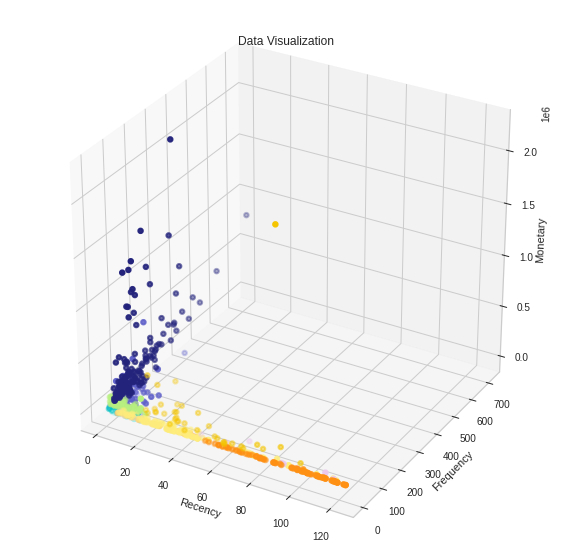

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.scatter(xChampion, yChampion, zChampion, c='#23237C', linewidth=2);
ax.scatter(xLoyal, yLoyal, zLoyal, c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, yPoLoyal, zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, yNewCust, zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, yPromis, zPromis, c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, yNeedAttent, zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(xAbout, yAbout, zAbout, c='#FBC57E', linewidth=2);
ax.scatter(xrisk, yrisk, zrisk, c='#F4C500', linewidth=2);
ax.scatter(xCantlose, yCantlose, zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, yHibernate, zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(xLost, yLost, zLost, c='#FF9014', linewidth=2);

#### Rlog(F)log(M) Graph

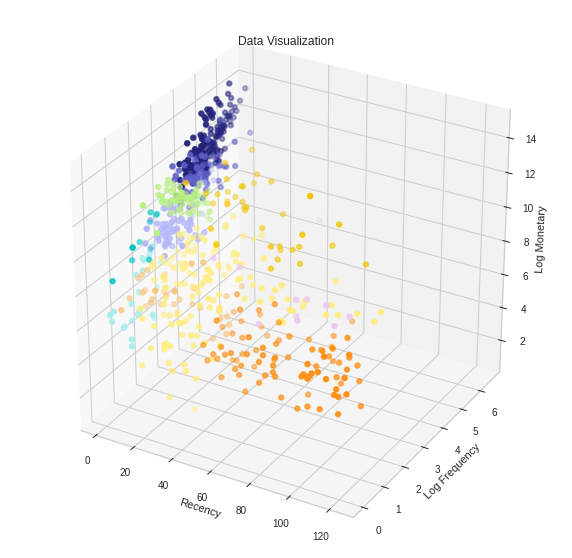

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Log Frequency')
ax.set_zlabel('Log Monetary')

ax.scatter(xChampion, logyChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter(xLoyal, logyLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, logyPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, logyNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, logyPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, logyNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(xAbout, logyAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter(xrisk, logyrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter(xCantlose, logyCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, logyHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(xLost, logyLost, logzLost, c='#FF9014', linewidth=2);

#### RF Graph

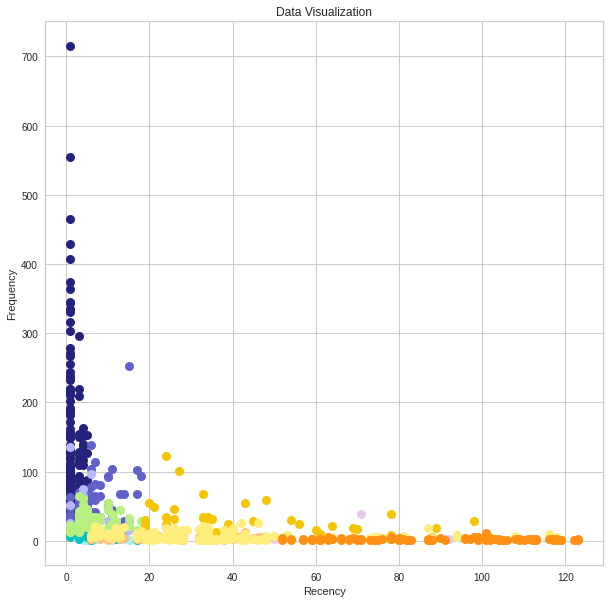

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_ylabel('Frequency')
ax.set_xlabel('Recency')


ax.scatter(xChampion, yChampion,  c='#23237C', linewidth=2);
ax.scatter(xLoyal, yLoyal,  c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, yPoLoyal,  c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, yNewCust,  c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, yPromis,  c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, yNeedAttent,  c='#B8F080', linewidth=2);
ax.scatter(xAbout, yAbout,  c='#FBC57E', linewidth=2);
ax.scatter(xrisk, yrisk,  c='#F4C500', linewidth=2);
ax.scatter(xCantlose, yCantlose,  c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, yHibernate,  c='#FFEE7C', linewidth=2);
ax.scatter(xLost, yLost,  c='#FF9014', linewidth=2);

#### Rlog(F) Graph

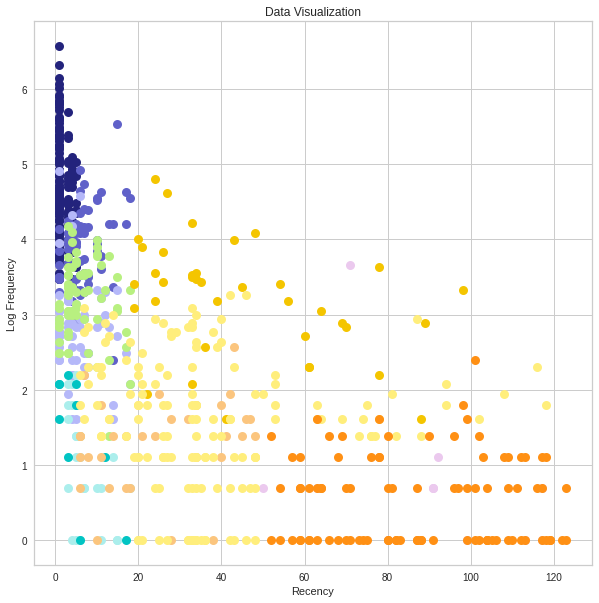

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()


plt.title('Data Visualization')
ax.set_ylabel('Log Frequency')
ax.set_xlabel('Recency')


ax.scatter(xChampion, logyChampion,  c='#23237C', linewidth=2);
ax.scatter(xLoyal, logyLoyal,  c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, logyPoLoyal,  c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, logyNewCust,  c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, logyPromis,  c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, logyNeedAttent,  c='#B8F080', linewidth=2);
ax.scatter(xAbout, logyAbout,  c='#FBC57E', linewidth=2);
ax.scatter(xrisk, logyrisk,  c='#F4C500', linewidth=2);
ax.scatter(xCantlose, logyCantlose,  c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, logyHibernate,  c='#FFEE7C', linewidth=2);
ax.scatter(xLost, logyLost,  c='#FF9014', linewidth=2);

#### RM Graph

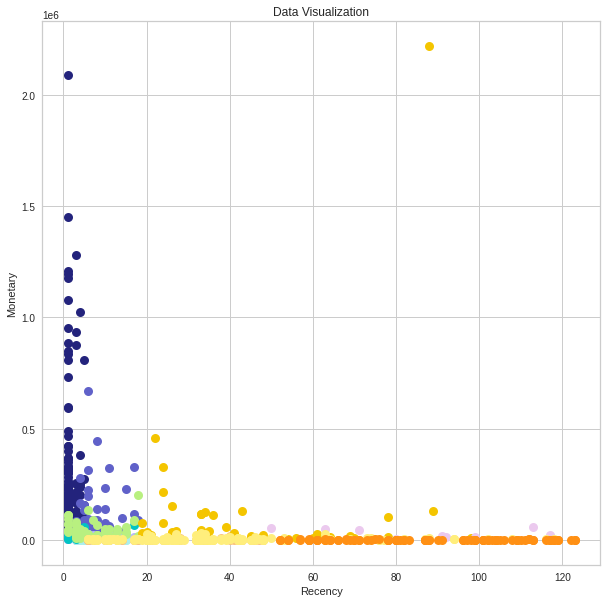

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')

ax.scatter( xChampion, zChampion, c='#23237C', linewidth=2);
ax.scatter( xLoyal, zLoyal, c='#6061C9', linewidth=2);
ax.scatter( xPoLoyal, zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter( xNewCust, zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter( xPromis, zPromis, c='#01C4C3', linewidth=2);
ax.scatter( xNeedAttent, zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter( xAbout, zAbout, c='#FBC57E', linewidth=2);
ax.scatter( xrisk, zrisk, c='#F4C500', linewidth=2);
ax.scatter( xCantlose, zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter( xHibernate, zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter( xLost, zLost, c='#FF9014', linewidth=2);

#### Rlog(M) Graph

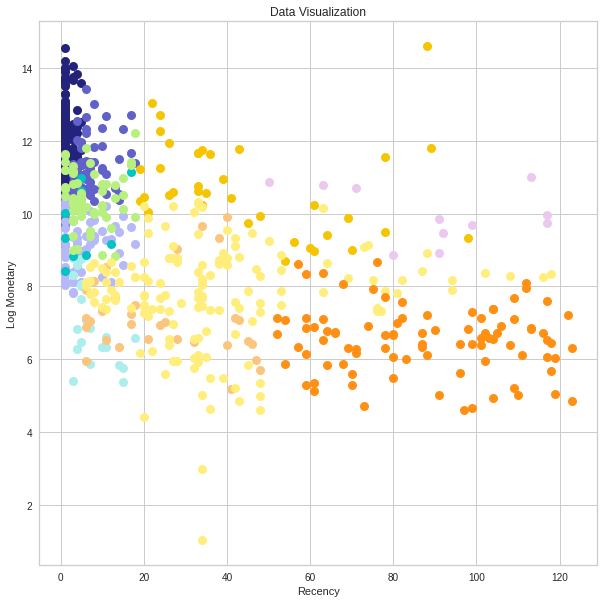

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Log Monetary')

ax.scatter( xChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter( xLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter( xPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter( xNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter( xPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter( xNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter( xAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter( xrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter( xCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter( xHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter( xLost, logzLost, c='#FF9014', linewidth=2);

#### FM Graph

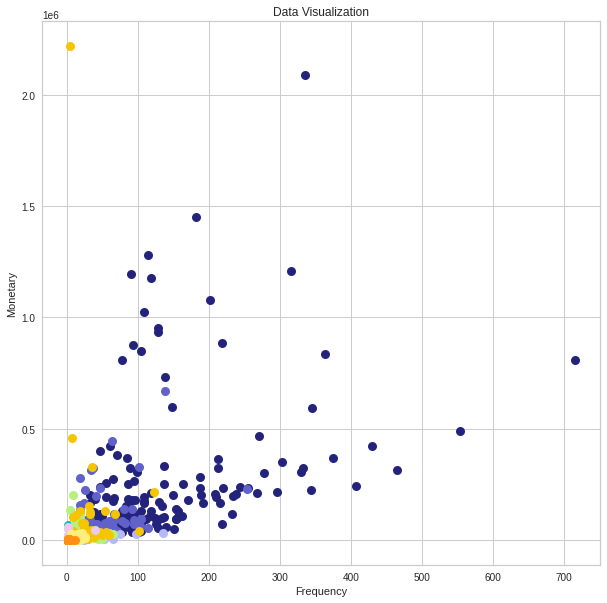

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax.scatter(yChampion,  zChampion, c='#23237C', linewidth=2);
ax.scatter(yLoyal,  zLoyal, c='#6061C9', linewidth=2);
ax.scatter(yPoLoyal,  zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(yNewCust,  zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(yPromis,  zPromis, c='#01C4C3', linewidth=2);
ax.scatter(yNeedAttent,  zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(yAbout,  zAbout, c='#FBC57E', linewidth=2);
ax.scatter(yrisk,  zrisk, c='#F4C500', linewidth=2);
ax.scatter(yCantlose,  zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(yHibernate,  zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(yLost,  zLost, c='#FF9014', linewidth=2);

#### log(F)log(M) Graph

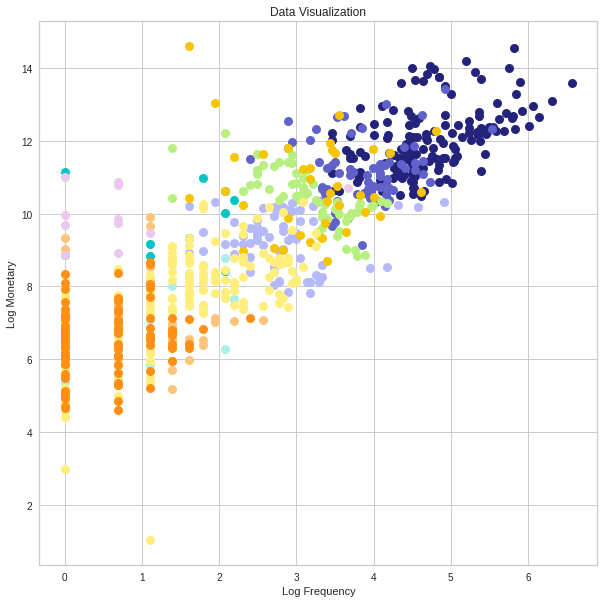

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Log Frequency')
ax.set_ylabel('Log Monetary')

ax.scatter(logyChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter(logyLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter(logyPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(logyNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(logyPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter(logyNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(logyAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter(logyrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter(logyCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(logyHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(logyLost, logzLost, c='#FF9014', linewidth=2);

#### RFM Mean

In [37]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency  Monetary      
             mean      mean      mean count
RFM_Score                                  
3            87.8       1.5     576.1    61
4            57.7       2.3    1111.3    62
5            50.8       3.8    3242.0    65
6            33.8       4.8    7410.2    53
7            28.4      10.6    7823.7    40
8            24.9      12.7   63984.0    44
9            14.6      18.6   29471.0    47
10           10.2      24.6   36516.2    51
11            7.6      35.7   50575.2    69
12            5.0      49.9   93233.2    52
13            3.5      78.9  113247.2    53
14            2.1     100.4  236906.8    41
15            1.0     200.1  380623.0    71

## Predict



In [ ]:
segmented_rfm

,รหัสลูกค้า,Recency,Frequency,Monetary,FM_Avg,R_Score,F_Score,M_Score,FM_Score,RFM_Segment,RFM_Score,Class
0,1,1,104,77560.83,4033163.16,5,5,4,5,554,14,Champion
1,2,1,85,121976.60,5184005.50,5,5,5,5,555,15,Champion
2,3,8,34,31417.00,534089.00,3,4,4,4,344,11,Loyal
3,4,1,128,950734.03,60846977.92,5,5,5,5,555,15,Champion
4,5,1,465,313464.16,72880417.20,5,5,5,5,555,15,Champion
...,...,...,...,...,...,...,...,...,...,...,...,...
704,705,5,4,6278.40,12556.80,4,2,2,2,422,8,New Customer
705,706,6,1,1209.60,604.80,3,1,1,1,311,5,New Customer
706,707,3,6,4050.37,12151.11,4,2,2,2,422,8,New Customer
707,708,7,22,5063.80,55701.80,3,3,2,3,332,8,Hibernating


In [ ]:
train_test_data = segmented_rfm.copy()
train_test_data.drop(columns=['รหัสลูกค้า','FM_Avg','R_Score','F_Score','M_Score','FM_Score','RFM_Segment','RFM_Score'],inplace=True)
train_test_data

,Recency,Frequency,Monetary,Class
0,1,104,77560.83,Champion
1,1,85,121976.60,Champion
2,8,34,31417.00,Loyal
3,1,128,950734.03,Champion
4,1,465,313464.16,Champion
...,...,...,...,...
704,5,4,6278.40,New Customer
705,6,1,1209.60,New Customer
706,3,6,4050.37,New Customer
707,7,22,5063.80,Hibernating


In [ ]:
#split dataset in features and target variable
# feature_cols = ['R_Score','F_Score','M_Score']
# feature_cols = ['Recency', 'Frequency', 'Monetary']
# feature_cols = ['Recency', 'Frequency', 'Monetary', 'R_Score','F_Score','M_Score','RFM_Segment','RFM_Score']
# X = segmented_rfm[feature_cols] # Features
# y = segmented_rfm.Class # Target variable

In [ ]:
# split X and y into training and testing sets

# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
train_data,test_data=train_test_split(train_test_data,test_size=0.3,random_state=0)

In [ ]:
train_data

,Recency,Frequency,Monetary,Class
546,42,5,1958.65,Hibernating
78,3,16,32287.54,Need Attention
92,92,3,13121.49,Can't lose them
490,32,2,696.00,Hibernating
66,43,10,6722.16,Hibernating
285,104,2,1588.78,Lost
451,3,29,18505.50,Need Attention
418,99,1,105.00,Lost
395,59,3,1260.00,Lost
650,99,1,16000.00,Can't lose them


In [ ]:
test_data

,Recency,Frequency,Monetary,Class
540,39,13,7554.77,Hibernating
467,3,114,1278440.00,Champion
355,6,3,2699.28,About to sleep
172,45,3,2618.21,Hibernating
637,1,47,9273.79,Loyal
665,1,13,9255.00,Potential Loyal
113,1,79,71482.32,Champion
40,8,81,138995.00,Loyal
363,12,18,5781.50,Hibernating
541,6,59,67626.71,Loyal


In [ ]:
#define target label and parameters
exp1 = setup(train_test_data, target = 'Class')

,Description,Value
0,session_id,7680
1,Target,Class
2,Target Type,Multiclass
3,Label Encoded,"About to sleep: 0, At risk: 1, ""Cant lose them..."
4,Original Data,"(709, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
dt = compare_models(fold = 5, turbo = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9073,0.9933,0.7941,0.9022,0.8987,0.8917,0.8928,0.348
rf,Random Forest Classifier,0.9054,0.9954,0.7845,0.9021,0.8957,0.8894,0.8908,0.552
gbc,Gradient Boosting Classifier,0.9053,0.9893,0.8030,0.9021,0.8970,0.8894,0.8908,1.172
dt,Decision Tree Classifier,0.8751,0.9306,0.7838,0.8853,0.8733,0.8547,0.8561,0.020
et,Extra Trees Classifier,0.8629,0.9908,0.7310,0.8484,0.8497,0.8391,0.8406,0.554
qda,Quadratic Discriminant Analysis,0.7318,0.9630,0.6420,0.7477,0.7291,0.6895,0.6919,0.024
nb,Naive Bayes,0.6288,0.9423,0.5548,0.6498,0.6174,0.5729,0.5790,0.022
lda,Linear Discriminant Analysis,0.5967,0.9086,0.3762,0.5357,0.5490,0.5239,0.5331,0.024
ridge,Ridge Classifier,0.5161,0.0000,0.2547,0.2967,0.3754,0.3982,0.4319,0.018
knn,K Neighbors Classifier,0.4921,0.8087,0.2792,0.4425,0.4548,0.3947,0.3997,0.142


In [ ]:
dt

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7680, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# creating a decision tree model
dt = create_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9000,0.0000,0.8833,0.9157,0.8934,0.8840,0.8857
1,0.9400,0.0000,0.9200,0.9483,0.9379,0.9303,0.9312
2,0.9400,0.0000,0.8431,0.9617,0.9477,0.9298,0.9307
3,0.8400,0.9911,0.6902,0.8133,0.8233,0.8115,0.8131
4,0.9400,1.0000,0.8485,0.9400,0.9260,0.9297,0.9319
5,0.9000,0.9971,0.8661,0.8972,0.8901,0.8843,0.8875
6,0.8776,0.0000,0.8000,0.8656,0.8645,0.8549,0.8571
7,0.9388,0.9995,0.8727,0.9235,0.9288,0.9282,0.9291
8,0.8776,0.9838,0.7545,0.8756,0.8669,0.8579,0.8608
9,0.9388,0.9996,0.8455,0.9277,0.9266,0.9284,0.9298


In [ ]:
dt

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7680, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# ensembling a trained dt model
dt_bagged = ensemble_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8800,0.0000,0.8367,0.8900,0.8694,0.8599,0.8623
1,0.9600,0.0000,0.9300,0.9652,0.9569,0.9534,0.9543
2,0.9400,0.0000,0.8506,0.9817,0.9568,0.9300,0.9317
3,0.8600,0.9878,0.7129,0.8340,0.8402,0.8351,0.8379
4,0.9600,1.0000,0.8788,0.9483,0.9504,0.9530,0.9539
5,0.9200,0.9946,0.8623,0.9102,0.9100,0.9067,0.9084
6,0.8980,0.0000,0.8200,0.8844,0.8825,0.8791,0.8818
7,0.9184,0.9970,0.8000,0.8736,0.8929,0.9039,0.9062
8,0.8776,0.9811,0.7545,0.8756,0.8669,0.8579,0.8608
9,0.9184,0.9968,0.8273,0.9156,0.9047,0.9045,0.9072


In [ ]:
dt_bagged

BaggingClassifier(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                class_weight=None,
                                                colsample_bytree=1.0,
                                                importance_type='split',
                                                learning_rate=0.1, max_depth=-1,
                                                min_child_samples=20,
                                                min_child_weight=0.001,
                                                min_split_gain=0.0,
                                                n_estimators=100, n_jobs=-1,
                                                num_leaves=31, objective=None,
                                                random_state=7680,
                                                reg_alpha=0.0, reg_lambda=0.0,
                                                silent='warn', subsample=1.0,
                                                s

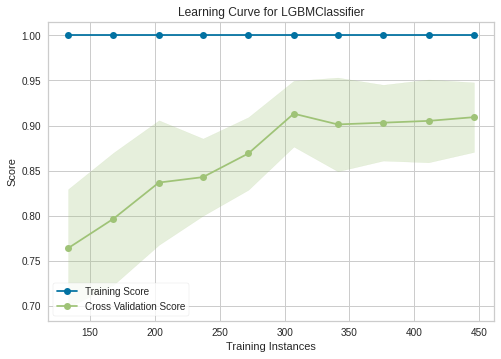

In [ ]:
#plot_model dt
plot_model(estimator = dt, plot = 'learning')

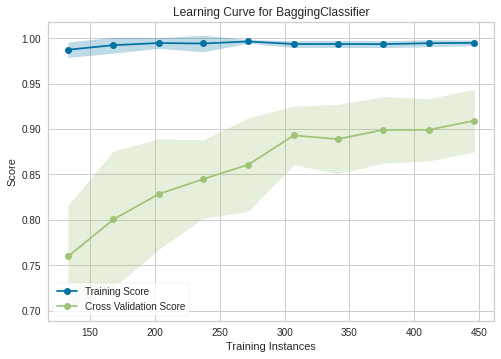

In [ ]:
# plot_model dt_bagged
plot_model(estimator = dt_bagged, plot = 'learning')

In [ ]:
#hyperparameters tunning
tuned_dt = tune_model(dt,optimize = "Accuracy", n_iter = 1000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8600,0.0000,0.8233,0.8814,0.8593,0.8374,0.8394
1,0.9200,0.0000,0.9033,0.9373,0.9190,0.9075,0.9092
2,0.9600,0.0000,0.8636,1.0000,0.9771,0.9534,0.9547
3,0.8800,0.9930,0.7342,0.8625,0.8626,0.8590,0.8619
4,0.8600,0.9912,0.7539,0.8732,0.8530,0.8349,0.8369
5,0.9000,0.9918,0.8568,0.8913,0.8910,0.8838,0.8851
6,0.8776,0.0000,0.6900,0.8483,0.8557,0.8543,0.8565
7,0.9592,0.9978,0.8909,0.9592,0.9592,0.9524,0.9524
8,0.9184,0.9870,0.8091,0.9100,0.9077,0.9054,0.9067
9,0.9388,0.9991,0.8455,0.9304,0.9275,0.9285,0.9298


In [ ]:
tuned_dt

LGBMClassifier(bagging_fraction=0.8, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=100, min_child_weight=0.001, min_split_gain=0,
               n_estimators=80, n_jobs=-1, num_leaves=100, objective=None,
               random_state=7680, reg_alpha=0.0001, reg_lambda=0.15,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
#evaluate model
evaluate_model(estimator=tuned_dt)

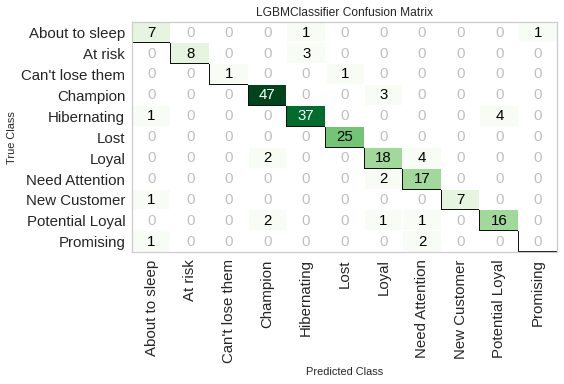

In [ ]:
#plot tuned dt confusion matrix
plot_model(tuned_dt, plot = 'confusion_matrix')

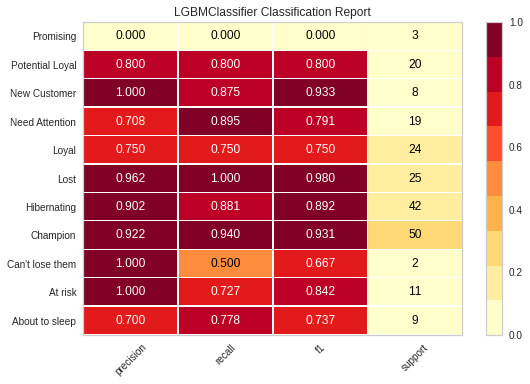

In [ ]:
#plot tuned dt confusion matrix
plot_model(tuned_dt, plot = 'class_report')

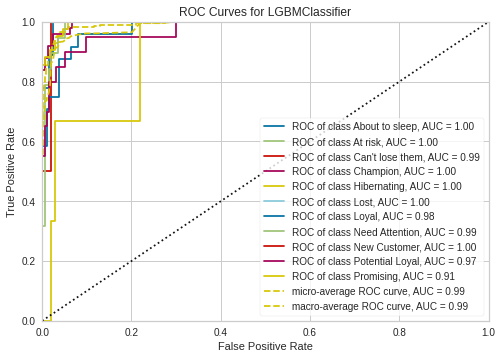

In [ ]:
#plot tuned dt confusion matrix
plot_model(tuned_dt, plot = 'auc')

In [ ]:
#predicting label on a new dataset
predictions = predict_model(dt, data = test_data)

In [ ]:
predictions

,Recency,Frequency,Monetary,Class,Label,Score
540,39,13,7554.77,Hibernating,Hibernating,0.9998
467,3,114,1278440.00,Champion,Champion,1.0000
355,6,3,2699.28,About to sleep,About to sleep,0.9997
172,45,3,2618.21,Hibernating,Hibernating,1.0000
637,1,47,9273.79,Loyal,Loyal,0.7728
...,...,...,...,...,...,...
676,34,13,1767.16,Hibernating,Hibernating,1.0000
263,6,138,669840.00,Loyal,Loyal,0.9997
463,96,4,606.99,Lost,Lost,0.9999
267,1,63,87709.99,Champion,Champion,0.9999


In [ ]:
save_model(dt, 'Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20,

## Regression

In [127]:
segmented_rfm

,รหัสลูกค้า,Recency,Frequency,Monetary,FM_Avg,R_Score,F_Score,M_Score,FM_Score,RFM_Segment,RFM_Score,Class
0,1,1,104,77560.83,4033163.16,5,5,4,5,554,14,Champion
1,2,1,85,121976.60,5184005.50,5,5,5,5,555,15,Champion
2,3,8,34,31417.00,534089.00,3,4,4,4,344,11,Loyal
3,4,1,128,950734.03,60846977.92,5,5,5,5,555,15,Champion
4,5,1,465,313464.16,72880417.20,5,5,5,5,555,15,Champion
...,...,...,...,...,...,...,...,...,...,...,...,...
704,705,5,4,6278.40,12556.80,4,2,2,2,422,8,New Customer
705,706,6,1,1209.60,604.80,3,1,1,1,311,5,New Customer
706,707,3,6,4050.37,12151.11,4,2,2,2,422,8,New Customer
707,708,7,22,5063.80,55701.80,3,3,2,3,332,8,Hibernating


In [128]:
train_test_data = segmented_rfm.copy()
train_test_data.drop(columns=['รหัสลูกค้า','FM_Avg','R_Score','F_Score','M_Score','FM_Score','RFM_Segment','RFM_Score'],inplace=True)
train_test_data

,Recency,Frequency,Monetary,Class
0,1,104,77560.83,Champion
1,1,85,121976.60,Champion
2,8,34,31417.00,Loyal
3,1,128,950734.03,Champion
4,1,465,313464.16,Champion
...,...,...,...,...
704,5,4,6278.40,New Customer
705,6,1,1209.60,New Customer
706,3,6,4050.37,New Customer
707,7,22,5063.80,Hibernating


In [129]:
# Champion > Loyal > Potential Loyal > 	New Customer > Promising > 	Need Attention > About to sleep > At risk	 > Can't lose them > Hibernating > Lost
train_test_data['Class'] = train_test_data['Class'].replace({'Champion':10, 'Loyal':9,'Potential Loyal':8,'New Customer':7,'Promising':6,'Need Attention':5,'About to sleep':4,'At risk':3,"Can't lose them":2,'Hibernating':1,'Lost':0})
train_test_data

,Recency,Frequency,Monetary,Class
0,1,104,77560.83,10
1,1,85,121976.60,10
2,8,34,31417.00,9
3,1,128,950734.03,10
4,1,465,313464.16,10
...,...,...,...,...
704,5,4,6278.40,7
705,6,1,1209.60,7
706,3,6,4050.37,7
707,7,22,5063.80,1


In [130]:
# split X and y into training and testing sets

# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
train_data,test_data=train_test_split(train_test_data,test_size=0.3,random_state=0)

In [131]:
train_data.shape

(496, 4)

In [132]:
test_data.shape

(213, 4)

In [133]:
# setup
reg = setup(data = train_test_data, target = 'Class')

,Description,Value
0,session_id,1143
1,Target,Class
2,Original Data,"(709, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(496, 3)"


In [134]:
# all the models that are available are 
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [135]:
best = compare_models(fold = 5, turbo = True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4367,0.6576,0.7988,0.9558,0.1876,0.1851,0.506
dt,Decision Tree Regressor,0.2624,0.9043,0.8987,0.9394,0.1722,0.1031,0.034
et,Extra Trees Regressor,0.5802,0.9619,0.9783,0.9353,0.2300,0.2649,0.464
lightgbm,Light Gradient Boosting Machine,0.6615,0.9660,0.9774,0.9349,0.2475,0.2853,0.112
gbr,Gradient Boosting Regressor,0.7355,1.1763,1.0827,0.9212,0.2678,0.3237,0.070
ada,AdaBoost Regressor,1.0843,1.6177,1.2677,0.8915,0.3590,0.4173,0.066
lr,Linear Regression,1.8979,4.7060,2.1682,0.6855,0.5513,0.8683,1.194
ridge,Ridge Regression,1.8979,4.7060,2.1682,0.6855,0.5513,0.8683,0.036
lar,Least Angle Regression,1.8979,4.7060,2.1682,0.6855,0.5513,0.8683,0.022
br,Bayesian Ridge,1.8981,4.7076,2.1686,0.6853,0.5506,0.8675,0.016


In [136]:
best

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1143, verbose=0, warm_start=False)

In [137]:
best_model = create_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3138,0.4365,0.6607,0.9732,0.1246,0.1088
1,0.2720,0.3685,0.6070,0.9778,0.1429,0.1283
2,0.5664,1.3624,1.1672,0.9034,0.2578,0.2894
3,0.5120,0.7022,0.8380,0.9523,0.1823,0.1638
4,0.3500,0.3140,0.5603,0.9786,0.1936,0.1160
5,0.3718,0.4007,0.6330,0.9720,0.1668,0.1483
6,0.4290,0.9743,0.9871,0.9465,0.2652,0.3740
7,0.3202,0.3163,0.5624,0.9772,0.0947,0.0751
8,0.4957,0.5874,0.7664,0.9489,0.1748,0.2091
9,0.3476,0.4372,0.6612,0.9725,0.1360,0.1118


In [138]:
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1143, verbose=0, warm_start=False)

In [139]:
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5226,0.7598,0.8717,0.9534,0.1743,0.1662
1,0.4291,0.4543,0.6740,0.9726,0.1851,0.1890
2,0.7431,1.7249,1.3133,0.8777,0.2830,0.3396
3,0.6868,0.9873,0.9937,0.9330,0.2338,0.2220
4,0.5558,0.6143,0.7838,0.9581,0.2359,0.2148
5,0.5047,0.5522,0.7431,0.9615,0.2024,0.2088
6,0.6310,1.3156,1.1470,0.9278,0.3031,0.4455
7,0.4543,0.3947,0.6282,0.9715,0.1286,0.1185
8,0.6857,0.9026,0.9501,0.9215,0.2244,0.2881
9,0.4856,0.6007,0.7750,0.9622,0.1812,0.1690


In [140]:
tuned_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.02,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=-1, oob_score=False,
                      random_state=1143, verbose=0, warm_start=False)

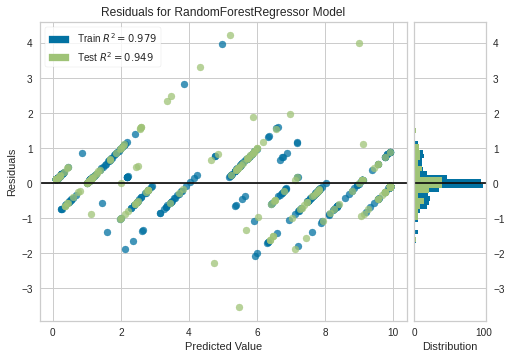

In [141]:
plot_model(tuned_model)

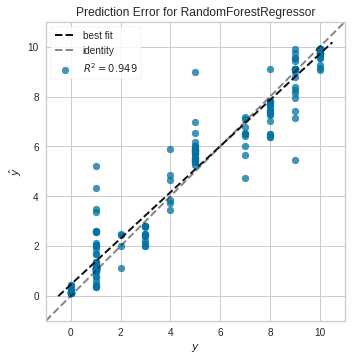

In [142]:
plot_model(tuned_model, plot = 'error')

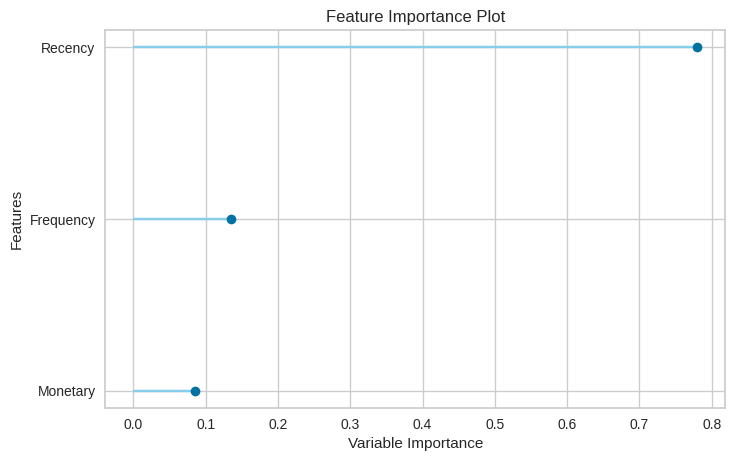

In [143]:
plot_model(tuned_model, plot = 'feature')

In [144]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [145]:
predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.537,0.7303,0.8546,0.9494,0.2094,0.2363


,Recency,Frequency,Monetary,Class,Label
0,1.0,202.0,1.078120e+06,10,9.908262
1,57.0,1.0,5.700000e+02,0,0.146673
2,26.0,46.0,3.727883e+04,3,2.804247
3,5.0,9.0,2.111490e+03,7,6.497351
4,48.0,59.0,2.085521e+04,3,2.475110
...,...,...,...,...,...
208,13.0,15.0,4.495000e+03,1,3.360435
209,14.0,4.0,5.644800e+02,4,4.650856
210,1.0,278.0,3.001639e+05,10,9.908262
211,117.0,2.0,2.000000e+03,0,0.205996


In [146]:
final_model = finalize_model(tuned_model)
final_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.02,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=-1, oob_score=False,
                      random_state=1143, verbose=0, warm_start=False)

In [147]:
predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3702,0.2858,0.5346,0.9802,0.1461,0.1467


,Recency,Frequency,Monetary,Class,Label
0,1.0,202.0,1.078120e+06,10,9.907037
1,57.0,1.0,5.700000e+02,0,0.162082
2,26.0,46.0,3.727883e+04,3,2.584078
3,5.0,9.0,2.111490e+03,7,7.197505
4,48.0,59.0,2.085521e+04,3,2.497422
...,...,...,...,...,...
208,13.0,15.0,4.495000e+03,1,1.527624
209,14.0,4.0,5.644800e+02,4,4.599961
210,1.0,278.0,3.001639e+05,10,9.907037
211,117.0,2.0,2.000000e+03,0,0.214017


In [151]:
prediction = predict_model(final_model, data = test_data)
prediction

,Recency,Frequency,Monetary,Class,Label
540,39,13,7554.77,1,1.330000
467,3,114,1278440.00,10,9.907037
355,6,3,2699.28,4,4.127203
172,45,3,2618.21,1,1.092306
637,1,47,9273.79,9,8.216152
...,...,...,...,...,...
676,34,13,1767.16,1,1.114405
263,6,138,669840.00,9,9.097073
463,96,4,606.99,0,0.159698
267,1,63,87709.99,10,9.907037


In [149]:
save_model(final_model, 'Final_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=10,
                                        max_features=1.0, max_leaf_nodes=None,
                                        max_samples=None,
                                  

In [150]:
# loaded_model = load_model('Final_Model')
# print(loaded_model)

## Churn Monitoring

In [216]:
churn_monitor = prediction.copy()
churn_monitor = churn_monitor.rename(columns = {'Class': 'Old_Class', 'Label': 'Predict_Class'}, inplace = False)
churn_monitor

,Recency,Frequency,Monetary,Old_Class,Predict_Class
540,39,13,7554.77,1,1.330000
467,3,114,1278440.00,10,9.907037
355,6,3,2699.28,4,4.127203
172,45,3,2618.21,1,1.092306
637,1,47,9273.79,9,8.216152
...,...,...,...,...,...
676,34,13,1767.16,1,1.114405
263,6,138,669840.00,9,9.097073
463,96,4,606.99,0,0.159698
267,1,63,87709.99,10,9.907037


In [217]:
churn_monitor['Predict_Class'] = churn_monitor['Predict_Class'].round().astype('int')
churn_monitor

,Recency,Frequency,Monetary,Old_Class,Predict_Class
540,39,13,7554.77,1,1
467,3,114,1278440.00,10,10
355,6,3,2699.28,4,4
172,45,3,2618.21,1,1
637,1,47,9273.79,9,8
...,...,...,...,...,...
676,34,13,1767.16,1,1
263,6,138,669840.00,9,9
463,96,4,606.99,0,0
267,1,63,87709.99,10,10


In [218]:
# Compare Class
churn_monitor['Monitor'] = (churn_monitor['Old_Class'] > churn_monitor['Predict_Class'])
churn_monitor['Monitor'] = churn_monitor['Monitor'].replace({True:'Churn', False:'Not_Churn'})
churn_monitor

,Recency,Frequency,Monetary,Old_Class,Predict_Class,Monitor
540,39,13,7554.77,1,1,Not_Churn
467,3,114,1278440.00,10,10,Not_Churn
355,6,3,2699.28,4,4,Not_Churn
172,45,3,2618.21,1,1,Not_Churn
637,1,47,9273.79,9,8,Churn
...,...,...,...,...,...,...
676,34,13,1767.16,1,1,Not_Churn
263,6,138,669840.00,9,9,Not_Churn
463,96,4,606.99,0,0,Not_Churn
267,1,63,87709.99,10,10,Not_Churn


In [219]:
# Churn
# Champion > Loyal > Potential Loyal > 	New Customer > Promising > 	Need Attention > About to sleep > At risk	 > Can't lose them > Hibernating > Lost

churn_monitor['Old_Class'] = churn_monitor['Old_Class'].replace({10:'Champion', 9:'Loyal', 8:'Potential Loyal', 7:'New Customer', 6:'Promising', 5:'Need Attention', 
                                                             4:'About to sleep', 3:'At risk', 2:"Can't lose them", 1:'Hibernating', 0:'Lost'})
churn_monitor['Predict_Class'] = churn_monitor['Predict_Class'].replace({10:'Champion', 9:'Loyal', 8:'Potential Loyal', 7:'New Customer', 6:'Promising', 5:'Need Attention', 
                                                             4:'About to sleep', 3:'At risk', 2:"Can't lose them", 1:'Hibernating', 0:'Lost'})
churn_monitor

,Recency,Frequency,Monetary,Old_Class,Predict_Class,Monitor
540,39,13,7554.77,Hibernating,Hibernating,Not_Churn
467,3,114,1278440.00,Champion,Champion,Not_Churn
355,6,3,2699.28,About to sleep,About to sleep,Not_Churn
172,45,3,2618.21,Hibernating,Hibernating,Not_Churn
637,1,47,9273.79,Loyal,Potential Loyal,Churn
...,...,...,...,...,...,...
676,34,13,1767.16,Hibernating,Hibernating,Not_Churn
263,6,138,669840.00,Loyal,Loyal,Not_Churn
463,96,4,606.99,Lost,Lost,Not_Churn
267,1,63,87709.99,Champion,Champion,Not_Churn


In [220]:
customer_churn = churn_monitor[churn_monitor['Monitor'].isin(['Churn'])]
customer_churn

,Recency,Frequency,Monetary,Old_Class,Predict_Class,Monitor
637,1,47,9273.79,Loyal,Potential Loyal,Churn
346,54,30,6042.00,At risk,Hibernating,Churn
683,5,11,4408.96,Potential Loyal,New Customer,Churn
505,69,18,19714.49,At risk,Can't lose them,Churn
271,88,5,2219724.00,At risk,Can't lose them,Churn
358,14,5,7425.00,Potential Loyal,New Customer,Churn
85,60,15,8584.00,At risk,Can't lose them,Churn
142,25,7,1130.07,About to sleep,At risk,Churn
375,34,6,0.00,About to sleep,At risk,Churn
10,18,8,9565.42,Potential Loyal,New Customer,Churn
